# Customer Segmentation with K-Means

K-Means is an unsupervised partitioning algorithm used to organize unlabelled data into groups or clusters.

Each cluster is defined by a central point called a centroid which is determined by the mathematical mean of all the points in that particular cluster.

**Rules:**
 1. Each point must belong to a cluster
 2. Each point can only belong to one cluster
 
**Steps:**
 1. Choose a reasonable k
 2. Randomly select k distinct data points
 3. Assign each remaining point to the nearest cluster
 4. Recalculate the center of the cluster points
 5. Repeat steps 3 and 4 until the algorithm converges i.e there are no more cluster reassignments.
 
`K-Means++` is the default implementation when you instantiate K-Means in scikit-learn.
It still randomly initializes centroids in the data but it does so based on a probability distrbution.
It randomly chooses one point within the data to be the first centroid, then it uses other data points as centroids selecting them pseudo-randomly.
The probability that a point will be selected as a centroid increases the further it is from other centroids. This helps ensure optimal model convergence.

In this project I use IBM's customer segmentation dataset. I could not find its documentation but will attempt to make sensse of the features the best way I can. Buckle up.

## Imports

In [1]:
# importing dependencies

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# reading in the data

customers=pd.read_csv('Customers.csv')

In [3]:
# first 5 observations

customers.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   Address          850 non-null    object 
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 66.5+ KB


## EDA

In [5]:
# descriptive statistics

customers.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Customer Id,850.0,425.500000,245.518160,1.000,213.25000,425.500,637.75000,850.000
Age,850.0,35.029412,8.041432,20.000,29.00000,34.000,41.00000,56.000
Edu,850.0,1.710588,0.927784,1.000,1.00000,1.000,2.00000,5.000
Years Employed,850.0,8.565882,6.777884,0.000,3.00000,7.000,13.00000,33.000
Income,850.0,46.675294,38.543054,13.000,24.00000,35.000,55.75000,446.000
Card Debt,850.0,1.576820,2.125843,0.012,0.38250,0.885,1.89850,20.561
Other Debt,850.0,3.078773,3.398799,0.046,1.04575,2.003,3.90325,35.197
Defaulted,700.0,0.261429,0.439727,0.000,0.00000,0.000,1.00000,1.000
DebtIncomeRatio,850.0,10.171647,6.719441,0.100,5.10000,8.700,13.80000,41.300


In [6]:
# checking the sum of nulls per column

customers.isnull().sum()

Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
Address              0
DebtIncomeRatio      0
dtype: int64

In [7]:
# getting rid of the null values

customers=customers.dropna(axis=0)

In [8]:
# confirming the nulls are gone

customers.isnull().sum()

Customer Id        0
Age                0
Edu                0
Years Employed     0
Income             0
Card Debt          0
Other Debt         0
Defaulted          0
Address            0
DebtIncomeRatio    0
dtype: int64

In [9]:
# checking for duplicates

customers[customers.duplicated()]

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio


None of our rows are duplicated since an empty DataFrame was returned.

In [10]:
# removing columns that are irrelevant

customers=customers.drop(['Customer Id', 'Address'], axis=1)

customers.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,41,2,6,19,0.124,1.073,0.0,6.3
1,47,1,26,100,4.582,8.218,0.0,12.8
2,33,2,10,57,6.111,5.802,1.0,20.9
3,29,2,4,19,0.681,0.516,0.0,6.3
4,47,1,31,253,9.308,8.908,0.0,7.2


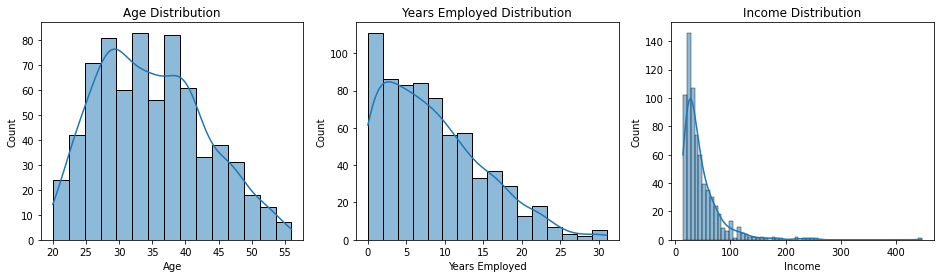

In [11]:
# plotting distributions

fig, axes = plt.subplots(1, 3, figsize=(16,4))

sns.histplot(data=customers, x='Age', kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')

sns.histplot(data=customers, x='Years Employed', kde=True, ax=axes[1])
axes[1].set_title('Years Employed Distribution')

sns.histplot(data=customers, x='Income', kde=True, ax=axes[2])
axes[2].set_title('Income Distribution');

Majority of the customers are in their late twenties to early fourties.

A vast majority of the customers have been employed for a decade or less. A small number have been emploed for more than a quarter of a century.

We have very few extremely high income earners. 

In [12]:
customers['Edu'].value_counts()

1    372
2    198
3     87
4     38
5      5
Name: Edu, dtype: int64

<AxesSubplot:xlabel='Edu', ylabel='count'>

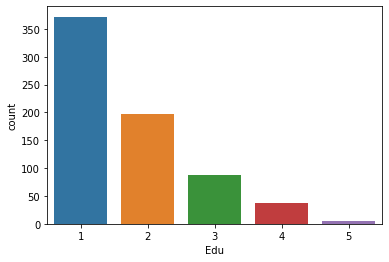

In [13]:
sns.countplot(data=customers, x='Edu')

Assuming 1 represents high school education level with 5 representing a doctorate, most of our customers have a high school diploma as the highest level of education. 

The number of customers trends downwards as the level of education increases.

<AxesSubplot:xlabel='Defaulted', ylabel='count'>

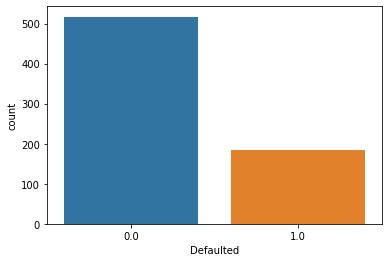

In [14]:
sns.countplot(data=customers, x='Defaulted')

Less than half of the customers are defaulters

<AxesSubplot:xlabel='Age', ylabel='Years Employed'>

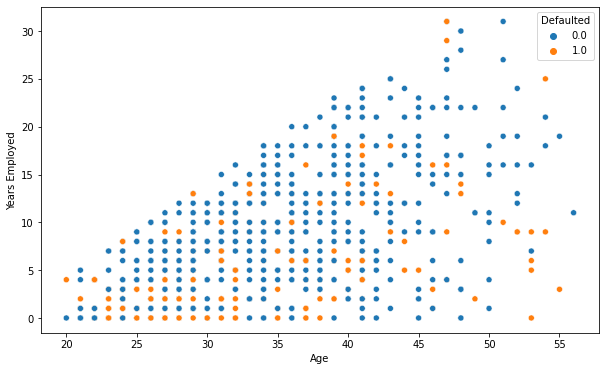

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=customers, x='Age', y='Years Employed', hue='Defaulted')

Naturally, the years in employment increase as one gets older.

<AxesSubplot:xlabel='Edu', ylabel='Income'>

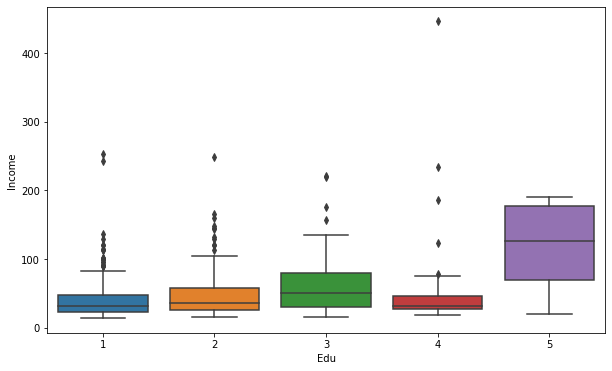

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(data=customers, x='Edu', y='Income')

The median income goes up as the level of education increases. 

Level 4 is the exception but it has an extreme income outlier. The median income for this level is lower than that of level 2 and level 3. 

Level 5 has the widest distribution of incomes and has zero outliers.

<AxesSubplot:xlabel='Edu', ylabel='Income'>

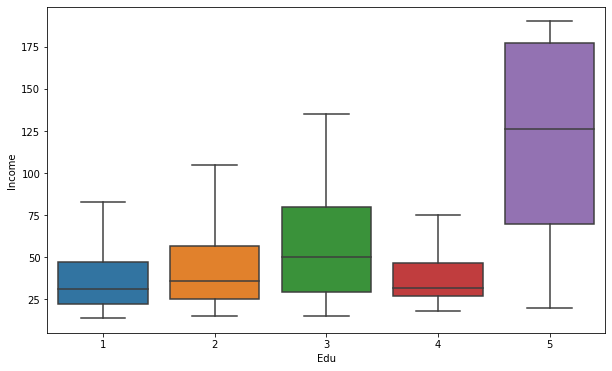

In [17]:
# same boxplots but without outliers

plt.figure(figsize=(10,6))
sns.boxplot(data=customers, x='Edu', y='Income', showfliers=False)

<AxesSubplot:ylabel='Edu'>

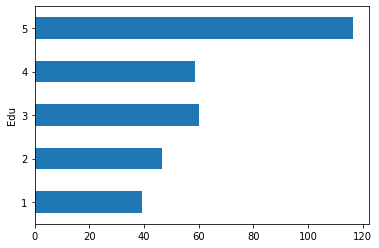

In [18]:
customers.groupby('Edu').mean()['Income'].plot(kind='barh')

The mean income of customers with a doctorate is considerably higher than the rest.

In [19]:
# feature engineering
# combining 'Card Debt' and 'Other Debt' into a single column ('Total Debt')

customers['Total Debt']=customers['Card Debt']+customers['Other Debt']

customers.sample(5)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total Debt
585,34,4,6,27,1.982,7.549,1.0,35.3,9.531
448,47,1,17,43,0.588,1.820,0.0,5.6,2.408
528,29,1,1,18,1.981,2.627,1.0,25.6,4.608
702,25,2,4,33,0.553,1.163,0.0,5.2,1.716
50,47,1,22,81,1.506,2.949,0.0,5.5,4.455


<AxesSubplot:xlabel='Total Debt', ylabel='Income'>

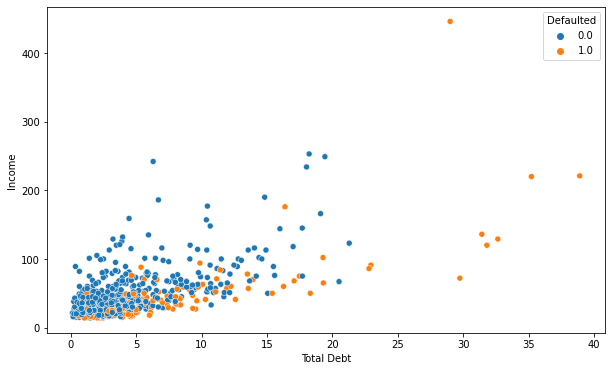

In [20]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=customers, y='Income', x='Total Debt', hue='Defaulted')

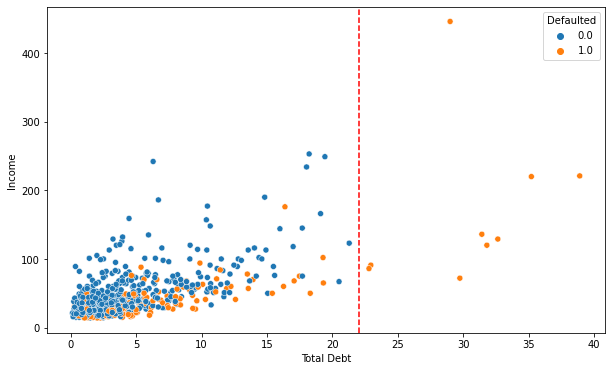

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=customers, y='Income', x='Total Debt', hue='Defaulted')
plt.axvline(22, ls='--', c='r')

All customers with a total debt above 22 defaulted.

<AxesSubplot:xlabel='Age', ylabel='Total Debt'>

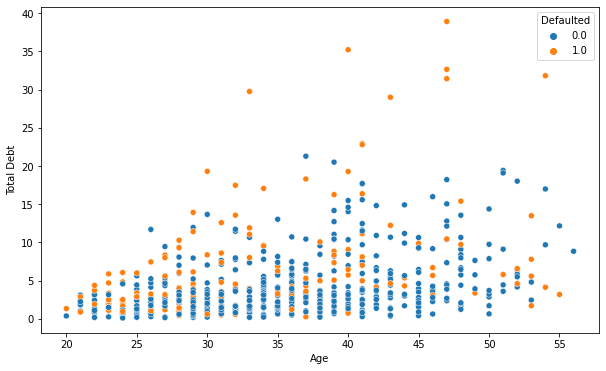

In [22]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=customers, x='Age', y='Total Debt', hue='Defaulted')

<AxesSubplot:xlabel='Edu', ylabel='DebtIncomeRatio'>

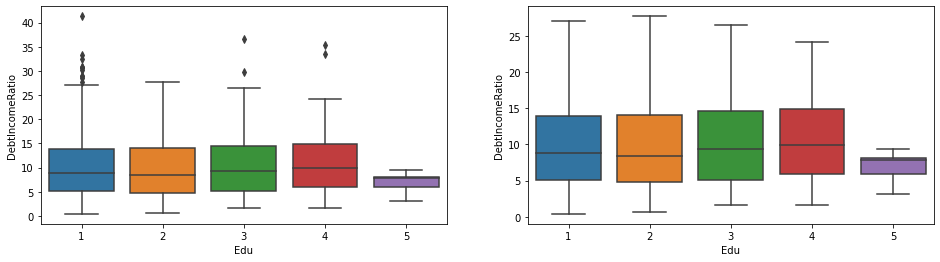

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))

sns.boxplot(data=customers, x='Edu', y='DebtIncomeRatio', ax=axes[0])
sns.boxplot(data=customers, x='Edu', y='DebtIncomeRatio', showfliers=False, ax=axes[1])

The first four education levels had more or less the same median debt to income ratio. Level 5 customers have a lower debt to income ratio and a much smaller spread.

<AxesSubplot:xlabel='Card Debt', ylabel='Other Debt'>

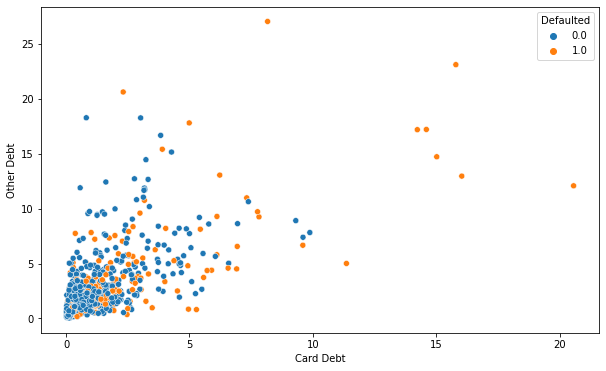

In [24]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=customers, x='Card Debt', y='Other Debt', hue='Defaulted')

All customers with card debt of 10 and above and other debt of at least 20 defaulted.

<AxesSubplot:xlabel='Total Debt', ylabel='Density'>

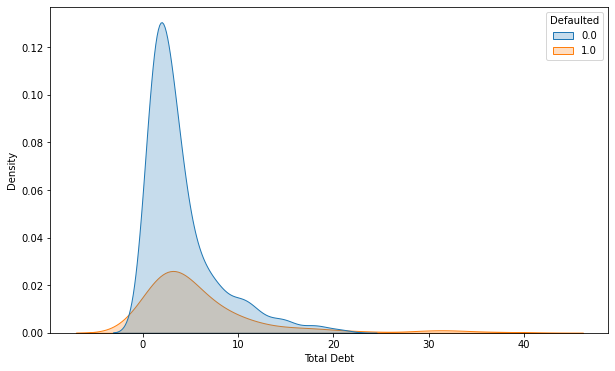

In [25]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=customers, x='Total Debt', hue='Defaulted', fill=True)

<AxesSubplot:ylabel='Defaulted'>

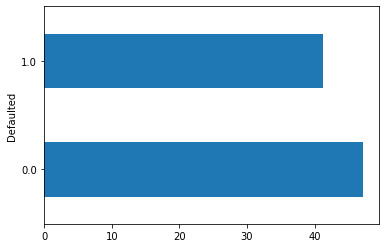

In [26]:
# comparing incomes of defaulters and non-defaulters

customers.groupby('Defaulted').mean()['Income'].plot(kind='barh')

Non-defaulters have a slightly higher average income.

<AxesSubplot:ylabel='Defaulted'>

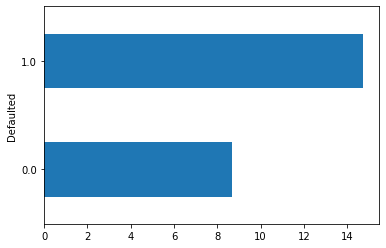

In [27]:
customers.groupby('Defaulted').mean()['DebtIncomeRatio'].plot(kind='barh')

The debt income ratio of defaulters was significantly higher than that of the non-defaulters.

## Preprocessing

In [28]:
# before we start modelling we need to handle outliers in our data
# we'll do so using z_scores

from scipy import stats

In [29]:
# calculating the zscore of the Income column and saving the result in a new column (z score)

customers['z score']=stats.zscore(customers['Income'])

customers.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total Debt,z score
0,41,2,6,19,0.124,1.073,0.0,6.3,1.197,-0.723102
1,47,1,26,100,4.582,8.218,0.0,12.8,12.800,1.478707
2,33,2,10,57,6.111,5.802,1.0,20.9,11.913,0.309845
3,29,2,4,19,0.681,0.516,0.0,6.3,1.197,-0.723102
4,47,1,31,253,9.308,8.908,0.0,7.2,18.216,5.637681


I covered z scores and outliers in this [notebook](https://github.com/Sabacon/Normal-Distribution-and-Z-score-Outlier-Detection).

In [30]:
# filtering out outlier based on z scores.
# remember z scores < -3 and z scores > 3 are considered outliers

customers_wo_outliers = customers[~((customers['z score']<-3) | (customers['z score']>3))]

customers_wo_outliers.sample(10)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total Debt,z score
305,37,2,6,62,1.186,4.084,0.0,8.5,5.270,0.445760
269,43,1,12,38,0.129,1.239,0.0,3.6,1.368,-0.206628
271,24,1,8,24,0.382,0.818,0.0,5.0,1.200,-0.587188
299,41,1,23,91,0.573,11.894,0.0,13.7,12.467,1.234062
232,27,1,11,56,4.637,4.827,0.0,16.9,9.464,0.282663
574,34,1,9,48,0.420,4.044,0.0,9.3,4.464,0.065200
12,24,1,7,18,0.526,0.643,0.0,6.5,1.169,-0.750285
617,27,2,7,30,0.448,0.752,1.0,4.0,1.200,-0.424091
433,22,3,0,18,0.478,0.908,0.0,7.7,1.386,-0.750285
615,32,2,5,43,1.806,4.644,1.0,15.0,6.450,-0.070714


In [31]:
# a dataframe without the aforementioned outliers

customers_wo_outliers=pd.DataFrame(customers_wo_outliers)

In [32]:
# dropping columns that will not be useful to us when modelling
# Default column can be construed as class labels
# since we combined Card Debt and Other Debt to form Total Debt, we need not include them

X=customers_wo_outliers.drop(['Defaulted','Card Debt','Other Debt', 'z score'], axis=1)

X.head()

,Age,Edu,Years Employed,Income,DebtIncomeRatio,Total Debt
0,41,2,6,19,6.3,1.197
1,47,1,26,100,12.8,12.800
2,33,2,10,57,20.9,11.913
3,29,2,4,19,6.3,1.197
6,38,2,4,56,1.6,0.896


**KMeans relies on distance metrics so scaling is a must.**

In [33]:
# importing standard scaler

from sklearn.preprocessing import StandardScaler

In [34]:
# instantiating the scaler

scaler=StandardScaler()

In [35]:
# fitting and transforming all of our data

scaled_X=scaler.fit_transform(X)

## Modelling

In [36]:
#  importing kmeans

from sklearn.cluster import KMeans

**Elbow Method**

Right out of the gate we'll attempt to find an 'optimum' number of clusters by looking at inertia and silhouette scores.

**Inertia** is the sum of squared distances between each observation and its nearest centroid. Essentially a measurement of how closely related observations are with other observations in the same cluster. The more compact the clusters are the lower the inertia. Inertia should therefore be as close to `0` as possible. An inertia of `0` is possible but doesn't offer any insight into the data as it would mean that either all the observations are identical or the number of clusters equals the number of observations.

**Silhouette scores** range from `-1` to `1`. `1` means than an observation is nicely tucked within it own cluster and well saparated from other clusters. Close to `0` means that an observation is on the boundary between clusters. `-1` means an obervation may be in the wrong cluster. We should aim for a k that maximizes the silhouette score.

We should opt for a cluster number that maximizes the silhouette score and one beyond which the reduction in inertia is not worth the addition of more clusters.

In [37]:
# create empty lists to store inertia and slhouette score respectively

inertia = []
sil_score = []

#importing silhouette score

from sklearn.metrics import silhouette_score

# running kmeans while looping through a range of k values

for k in range(2,11):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(scaled_X)
    
    # appending values into the empty lists
    inertia.append(kmeans.inertia_)
    sil_score.append(silhouette_score(scaled_X, kmeans.labels_))

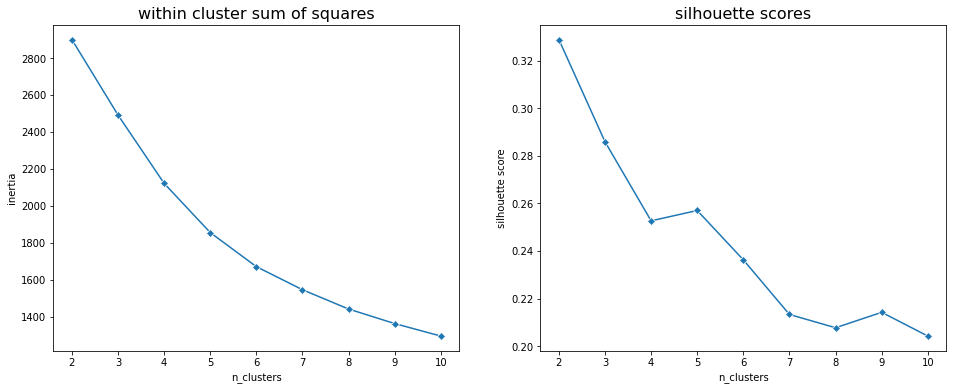

In [38]:
# plotting the within cluster sum of squares (inertia) and silhouette scores

fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.lineplot(x=range(2,11), y=inertia, marker='D', ax=axes[0])
axes[0].set_title('within cluster sum of squares', fontsize=16)
axes[0].set_xlabel('n_clusters')
axes[0].set_ylabel('inertia')

sns.lineplot(x=range(2,11), y=sil_score, marker='D', ax=axes[1])
axes[1].set_title('silhouette scores', fontsize=16)
axes[1].set_xlabel('n_clusters')
axes[1].set_ylabel('silhouette score');

Plotting inertia suggests 5 or 6 clusters. Looking at the plot of silhouette scores, 2 clusters result in the highest score.

The `Defaulted` column we dropped suggested we group our customers into defaulters and non-defaulters.

We'll go with 5.

Do not forget that the optimum number of clusters is subjective and depends on one's goals from the clustering process.

In [39]:
# model with 'optimal' number of clusters

kmeans_opt=KMeans(n_clusters=5)

kmeans_opt.fit(X)

KMeans(n_clusters=5)

## Results

In [40]:
# adding the cluster labels to our data

customers_wo_outliers['Clusters']=kmeans_opt.labels_

In [41]:
customers_wo_outliers.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Total Debt,z score,Clusters
0,41,2,6,19,0.124,1.073,0.0,6.3,1.197,-0.723102,3
1,47,1,26,100,4.582,8.218,0.0,12.8,12.800,1.478707,1
2,33,2,10,57,6.111,5.802,1.0,20.9,11.913,0.309845,0
3,29,2,4,19,0.681,0.516,0.0,6.3,1.197,-0.723102,2
6,38,2,4,56,0.442,0.454,0.0,1.6,0.896,0.282663,0


In [42]:
customers_wo_outliers['Clusters'].value_counts()

2    225
3    199
0    137
4     86
1     39
Name: Clusters, dtype: int64

In [43]:
customers_wo_outliers.groupby('Clusters').mean()[['Age', 'Income', 'Total Debt']]

,Age,Income,Total Debt
Clusters,,,
0,37.350365,49.766423,5.487664
1,43.769231,114.282051,10.817846
2,27.808889,21.480000,2.373733
3,36.115578,32.050251,2.749176
4,40.779070,73.941860,8.442860


<AxesSubplot:xlabel='Clusters'>

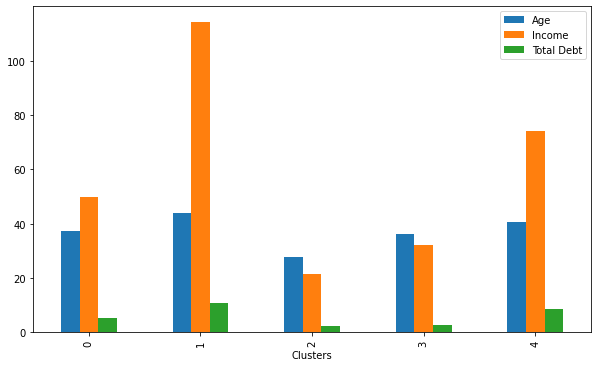

In [44]:
customers_wo_outliers.groupby('Clusters').mean()[['Age', 'Income', 'Total Debt']].plot.bar(figsize=(10,6))

In [45]:
customers_wo_outliers.groupby(['Clusters', 'Defaulted']).size()

Clusters  Defaulted
0         0.0          104
          1.0           33
1         0.0           35
          1.0            4
2         0.0          138
          1.0           87
3         0.0          162
          1.0           37
4         0.0           68
          1.0           18
dtype: int64

## Thank you